In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
import matplotlib.colors
from tqdm import tqdm_notebook
import seaborn as sns
import imageio

import warnings
warnings.filterwarnings('ignore')

## 1. Load the data

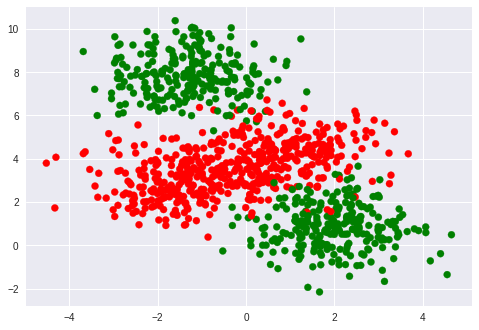

In [2]:
from sklearn.datasets import make_blobs

data, labels = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","green"])

labels_orig = labels
labels = np.mod(labels_orig, 2)
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, stratify=labels, random_state=0)
print(X_train.shape, X_test.shape)

(750, 2) (250, 2)


$$\frac{∂}{∂h}\left(-\left(y\left(\ln \left(h\right)\right)+\left(1-y\right)\left(\ln \left(1-h\right)\right)\right)\right) = -\frac{y-h}{h\left(-h+1\right)}$$

## 2. Exercise 1: Vectorized Simple Neural Network

$$ W1 \space W3 \\W2 \space W4$$

In [0]:
W1 = np.random.rand(2,2)
B1 = np.random.rand(1,2)

W2 = np.random.rand(2,1)
B2 = np.random.rand(1,1)

## 2.1 NN vectorized class with all algorithms

In [0]:
class simple_NN_vectorized:
  def __init__(self,W1,W2):
    self.W1 = W1.copy()
    self.B1 = np.zeros(shape=(1,2))
    
    self.W2 = W2.copy()
    self.B2 = 0
    
    self.W1_h = []
    self.W2_h = []
    self.B1_h = []
    self.B2_h = []
    self.error_h = []
    
    
  def sigmoid(self,X):
    return 1/(1+np.exp(-X))
  
  def error(self,X=None,Y=None,W1=None,W2=None,B1=None,B2=None):
    if X is None:
      X = self.X
      
    if Y is None:
      Y = self.Y
      
    if W1 is None:
      W1 = self.W1
      
    if W2 is None:
      W2 = self.W2
      
    if B1 is None:
      B1 = self.B1
      
    if B2 is None:
      B2 = self.B2
      
    Y_pred = self.forward_pass(X,W1,W2,B1,B2)
    error = mean_squared_error(Y,Y_pred)
    return error
  
  def forward_pass(self,X,W1=None,W2=None,B1=None,B2=None):
    
    if W1 is None:
      W1 = self.W1
      
    if W2 is None:
      W2 = self.W2
      
    if B1 is None:
      B1 = self.B1
      
    if B2 is None:
      B2 = self.B2
   
    # forward pass to layer 1
    self.A1 = np.matmul(X,W1) + B1 # (N,2)*(2,2) + (1,2) = (N,2)
    self.H1 = self.sigmoid(self.A1) # (N, 2)
            
    # forward pass to layer 2
    self.A2 = np.matmul(self.H1,W2) + B2 # (N,2)*(2,1) + (1,1) = (N,1)
    self.H2 = self.sigmoid(self.A2) # (N,1)
        
    return self.H2
    
  def grad_sigmoid(self, X):
    return X*(1-X) 
  
  def grad(self,X,Y,W1=None,W2=None,B1=None,B2=None):
    
    if W1 is None:
      W1 = self.W1
      
    if W2 is None:
      W2 = self.W2
      
    if B1 is None:
      B1 = self.B1
      
    if B2 is None:
      B2 = self.B2
 
    self.forward_pass(X,W1,W2,B1,B2)
    Y = Y.reshape(-1,1)
        
    # backpropagation from loss to output layer
    
    self.dA2 = np.multiply(self.H2-Y,np.multiply(self.H2,(1-self.H2))) # (N,1)
    self.dW2 = np.matmul(self.H1.T,self.dA2) # (2,N)*(N,1)  = (2,1) 
    self.dB2 = np.sum(self.dA2,axis=0).reshape(1,-1) # (1,1)
    
    self.dH1 = np.matmul(self.dA2,W2.T) # (N, 1)*(1, 2) = (N, 2)
    self.dA1 = np.multiply(self.dH1,self.grad_sigmoid(self.H1)) # (N,2).*(N,2) = (N,2)
    
    self.dW1 = np.matmul(X.T,self.dA1) # (2,N) * (N,2) = (2,2) 
    self.dB1 = np.sum(self.dA1,axis=0).reshape(1,-1) # (1,2) 
     
  def fit(self,X,Y,epochs=1,learning_rate=1,display_loss=True, algorithm='GD',gamma=0.9,batch_size=32,eps=1e-8,beta=0.9,beta1=0.9,beta2=0.99):
    
    m = X.shape[0]
    self.X,self.Y = X,Y
    if display_loss:
      loss = {}
      
    
    if algorithm == 'GD':
      
      for i in tqdm_notebook(range(epochs),unit='epoch',total=epochs):

        self.grad(X,Y)

        self.W1 -= learning_rate*self.dW1/m
        self.B1 -= learning_rate*self.dB1/m

        self.W2 -= learning_rate*self.dW2/m
        self.B2 -= learning_rate*self.dB2/m  
        
        # store the history of the weights and biases
        self.append_log()
        
        if display_loss:
          Y_pred = self.predict(X)
          loss[i] = mean_squared_error(Y,Y_pred)
          
    if algorithm == 'MiniBatch':
      
      for i in tqdm_notebook(range(epochs),unit='epoch',total=epochs):
        X_batch = []
        Y_batch = []
        for n,(x,y) in enumerate(zip(X,Y),start=1):
          X_batch.append(x)
          Y_batch.append(y)
          if batch_size % n == 0:
            X_n = np.array(X_batch)
            Y_n = np.array(Y_batch)
            self.grad(X_n,Y_n)

            self.W1 -= learning_rate*self.dW1/m
            self.B1 -= learning_rate*self.dB1/m

            self.W2 -= learning_rate*self.dW2/m
            self.B2 -= learning_rate*self.dB2/m  

        # store the history of the weights and biases
            self.append_log()
        
        if display_loss:
          Y_pred = self.predict(X)
          loss[i] = mean_squared_error(Y,Y_pred)
      
    if algorithm == 'Momentum':
      
      V_W1 = np.zeros(shape=(2,2))
      V_B1 = np.zeros(shape=(1,2))

      V_W2 = np.zeros(shape=(2,1))
      V_B2 = 0
      
      for i in tqdm_notebook(range(epochs),unit='epoch',total=epochs):
        self.grad(X,Y)
       
        V_W1 = gamma*V_W1 + learning_rate*self.dW1/m
        V_B1 = gamma*V_B1 + learning_rate*self.dB1/m

        V_W2 = gamma*V_W2 + learning_rate*self.dW2/m
        V_B2 = gamma*V_B2 + learning_rate*self.dB2/m  
        
        self.W1 -= V_W1
        self.W2 -= V_W2
        self.B1 -= V_B1
        self.B2 -= V_B2
        
        # store the history of the weights and biases
        self.append_log()

        if display_loss:
          Y_pred = self.predict(X)
          loss[i] = mean_squared_error(Y,Y_pred)
          
    if algorithm == 'NAG':
      
      V_W1 = np.zeros(shape=(2,2))
      V_B1 = np.zeros(shape=(1,2))

      V_W2 = np.zeros(shape=(2,1))
      V_B2 = 0
      
      W1_temp = self.W1 - gamma*V_W1
      W2_temp = self.W2 - gamma*V_W2
      B1_temp = self.B1 - gamma*V_B1
      B2_temp = self.B2 - gamma*V_B2
      
      for i in tqdm_notebook(range(epochs),unit='epoch',total=epochs):
        self.grad(X,Y,W1=W1_temp, W2=W2_temp,B1=B1_temp,B2=B2_temp)
       
        V_W1 = gamma*V_W1 + learning_rate*self.dW1/m
        V_B1 = gamma*V_B1 + learning_rate*self.dB1/m

        V_W2 = gamma*V_W2 + learning_rate*self.dW2/m
        V_B2 = gamma*V_B2 + learning_rate*self.dB2/m  
        
        
        W1_temp = self.W1 - gamma*V_W1
        W2_temp = self.W2 - gamma*V_W2
        B1_temp = self.B1 - gamma*V_B1
        B2_temp = self.B2 - gamma*V_B2
        
        self.W1 -= V_W1
        self.W2 -= V_W2
        self.B1 -= V_B1
        self.B2 -= V_B2
        
        # store the history of the weights and biases
        self.append_log()

        if display_loss:
          Y_pred = self.predict(X)
          loss[i] = mean_squared_error(Y,Y_pred) 
          
    if algorithm == 'Adagrad':
      
      V_W1 = np.zeros(shape=(2,2))
      V_B1 = np.zeros(shape=(1,2))

      V_W2 = np.zeros(shape=(2,1))
      V_B2 = 0
      
      for i in tqdm_notebook(range(epochs),unit='epoch',total=epochs):
        
        self.grad(X,Y)
       
        V_W1 = V_W1 + np.square(self.dW1)
        V_B1 = V_B1 + np.square(self.dB1)

        V_W2 = V_W2 + np.square(self.dW2)
        V_B2 = V_B2 + np.square(self.dB2)
        
        self.W1 -= learning_rate*self.dW1/(np.sqrt(V_W1)+eps)
        self.W2 -= learning_rate*self.dW2/(np.sqrt(V_W2)+eps)
        self.B1 -= learning_rate*self.dB1/(np.sqrt(V_B1)+eps)
        self.B2 -= learning_rate*self.dB2/(np.sqrt(V_B2)+eps)
        
        # store the history of the weights and biases
        self.append_log()

        if display_loss:
          Y_pred = self.predict(X)
          loss[i] = mean_squared_error(Y,Y_pred)      
    
    if algorithm == 'RMSProp':
      
      V_W1 = np.zeros(shape=(2,2))
      V_B1 = np.zeros(shape=(1,2))

      V_W2 = np.zeros(shape=(2,1))
      V_B2 = 0
      
      for i in tqdm_notebook(range(epochs),unit='epoch',total=epochs):
        
        self.grad(X,Y)
       
        V_W1 = beta*V_W1 + (1-beta)*np.square(self.dW1)
        V_B1 = beta*V_B1 + (1-beta)*np.square(self.dB1)

        V_W2 = beta*V_W2 + (1-beta)*np.square(self.dW2)
        V_B2 = beta*V_B2 + (1-beta)*np.square(self.dB2)
        
        self.W1 -= learning_rate*self.dW1/(np.sqrt(V_W1)+eps)
        self.W2 -= learning_rate*self.dW2/(np.sqrt(V_W2)+eps)
        self.B1 -= learning_rate*self.dB1/(np.sqrt(V_B1)+eps)
        self.B2 -= learning_rate*self.dB2/(np.sqrt(V_B2)+eps)
        
        # store the history of the weights and biases
        self.append_log()

        if display_loss:
          Y_pred = self.predict(X)
          loss[i] = mean_squared_error(Y,Y_pred) 
          
          
    if algorithm == 'Adam':
      
      M_W1 = np.zeros(shape=(2,2))
      M_B1 = np.zeros(shape=(1,2))
      M_W2 = np.zeros(shape=(2,1))
      M_B2 = 0
      
      V_W1 = np.zeros(shape=(2,2))
      V_B1 = np.zeros(shape=(1,2))
      V_W2 = np.zeros(shape=(2,1))
      V_B2 = 0
      
      n = 0
      
      for i in tqdm_notebook(range(epochs),unit='epoch',total=epochs):
        n += 1
        self.grad(X,Y)
        
        # Momentum
        M_W1 = beta1*M_W1 + (1-beta1)*self.dW1
        M_B1 = beta1*M_B1 + (1-beta1)*self.dB1
        M_W2 = beta1*M_W2 + (1-beta1)*self.dW2
        M_B2 = beta1*M_B2 + (1-beta1)*self.dB2
        
        
        V_W1 = beta2*V_W1 + (1-beta2)*np.square(self.dW1)
        V_B1 = beta2*V_B1 + (1-beta2)*np.square(self.dB1)
        V_W2 = beta2*V_W2 + (1-beta2)*np.square(self.dW2)
        V_B2 = beta2*V_B2 + (1-beta2)*np.square(self.dB2)
        
        
        # Bias correction 
        M_W1_C = M_W1/(1-np.power(beta1,n))
        M_B1_C = M_B1/(1-np.power(beta1,n))
        M_W2_C = M_W2/(1-np.power(beta1,n))
        M_B2_C = M_B2/(1-np.power(beta1,n))
        
        
        V_W1_C = V_W1/(1-np.power(beta2,n))
        V_B1_C = V_B1/(1-np.power(beta2,n))
        V_W2_C = V_W2/(1-np.power(beta2,n))
        V_B2_C = V_B2/(1-np.power(beta2,n))
        
        self.W1 -= learning_rate*M_W1_C/(np.sqrt(V_W1_C)+eps)
        self.W2 -= learning_rate*M_W2_C/(np.sqrt(V_W2_C)+eps)
        self.B1 -= learning_rate*M_B1_C/(np.sqrt(V_B1_C)+eps)
        self.B2 -= learning_rate*M_B2_C/(np.sqrt(V_B2_C)+eps)
        
        # store the history of the weights and biases
        self.append_log()

        if display_loss:
          Y_pred = self.predict(X)
          loss[i] = mean_squared_error(Y,Y_pred) 
    
    if display_loss:
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      plt.ylabel('Mean Squared Error')
      plt.title('Vectorized Simple Neural Network with ' + algorithm)
      plt.show()
      
  def predict(self,X):
      Y_pred = self.forward_pass(X)
      return np.array(Y_pred)
    
  def predict_H1(self,X,W,B):
    # forward pass to layer 1
    A = np.matmul(X,W) + B # (N,2)*(2,2) + (1,2) = (N,2)
    H = self.sigmoid(A) # (N, 2)
    return H
  
  def append_log(self):
    # store the history of the weights and biases
    self.W1_h.append(self.W1)
    self.W2_h.append(self.W2)
    self.B1_h.append(self.B1)
    self.B2_h.append(self.B2)
    self.error_h.append(self.error())
    
  def return_W1(self):
    w1_h = []
    w2_h = []
    for W in self.W1_h:
      w1_h.append(W[0][0])
      w2_h.append(W[1][0])
    return w1_h,w2_h
                

## 2.2 Initializing the class

In [6]:
algorithms = ['GD','Momentum','NAG','MiniBatch','Adagrad','RMSProp','Adam']
models = []
epochs = 50
for algorithm in algorithms:
  NN = simple_NN_vectorized(W1,W2)
  NN.fit(X_train,Y_train,epochs=epochs,learning_rate=1,display_loss=False, algorithm=algorithm,gamma=0.9,batch_size=128,eps=1e-8,beta=0.4,beta1=0.9,beta2=0.99)
  models.append(NN)

In [7]:
for algo,NN in zip(algorithms,models):
  print(algo)
  Y_predict = NN.predict(X_train)
  Y_predict_binarised = (Y_predict>=0.5).astype(np.int)
  print('Train accuracy',accuracy_score(Y_predict_binarised,Y_train))

  Y_predict_test = NN.predict(X_test)
  Y_predict_binarised_test = (Y_predict_test>=0.5).astype(np.int)
  print('Test accuracy',accuracy_score(Y_predict_binarised_test,Y_test))
  print('*'*25)

GD
Train accuracy 0.6653333333333333
Test accuracy 0.664
*************************
Momentum
Train accuracy 0.6733333333333333
Test accuracy 0.636
*************************
NAG
Train accuracy 0.6733333333333333
Test accuracy 0.636
*************************
MiniBatch
Train accuracy 0.5613333333333334
Test accuracy 0.588
*************************
Adagrad
Train accuracy 0.7306666666666667
Test accuracy 0.716
*************************
RMSProp
Train accuracy 0.7186666666666667
Test accuracy 0.712
*************************
Adam
Train accuracy 0.724
Test accuracy 0.72
*************************


## 3. Visualization of each neuron

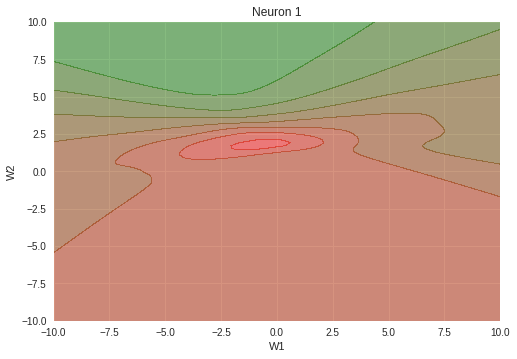

In [10]:
W1 = NN.W1.copy()

fig = plt.figure()

mini = np.min(NN.W1_h)
maxi = np.max(NN.W1_h)

x1 = np.linspace(-10,10,100)
x2 = np.linspace(-10,10,100)
X1,X2 = np.meshgrid(x1,x2)

E1 = np.zeros(X1.shape)

for row in range(X1.shape[0]):
  for col in range(X2.shape[1]):
    w1,w2 = x1[col],x2[row]
    W1[0][0] = w1
    W1[1][0] = w2
    E1[row,col]=NN.error(X_train,Y_train,W1=W1)
    
    
plt.contourf(X1,X2,E1,cmap=my_cmap,alpha=0.5)
plt.xlabel('W1')
plt.ylabel('W2')
plt.title('Neuron 1')

for nn,algo in zip(models,algorithms):
  w1_h,w2_h = nn.return_W1()
  plt.plot(w1_h,w2_h,lw=4)

plt.show()